# American Sign Language Gesture Recognizer (CNN-Based)

This notebook trains a **Convolutional Neural Network (CNN)** for recognizing American Sign Language gestures using the dataset from Hugging Face: `asthalochan/American_Sign_Language`

## Model Architecture
- **CNN-based**: Uses ResNet18 (Convolutional Neural Network) with transfer learning
- **Real-time capable**: Optimized for fast inference on camera feed
- **Accurate**: Transfer learning from ImageNet for better feature extraction

## Overview
1. Environment setup and GPU detection
2. Dataset loading and exploration  
3. Data preprocessing and augmentation
4. CNN Model architecture (ResNet18 Transfer Learning)
5. Training with mixed precision
6. Evaluation and error analysis
7. Model export and deployment
8. **🎥 Real-time camera inference - Test with your webcam!**

## 1. GPU/Environment Check and Reproducibility Seed

In [1]:
import os
# Disable torchcodec to avoid FFmpeg/libtorchcodec load issues in CPU-only or incompatible setups
os.environ["TORCH_DISABLE_LIBTORCHCODEC"] = "1"

import torch
import numpy as np
import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Enable deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("No GPU available, using CPU")

print(f"\nRandom seed set to: {SEED}")

PyTorch version: 2.9.0+cpu
Device: cpu
No GPU available, using CPU

Random seed set to: 42


## 2. Install and Import Dependencies

In [2]:
# Install required packages
%pip install -q datasets torchvision torchmetrics timm scikit-learn onnxruntime matplotlib seaborn pillow tqdm "huggingface_hub>=0.34,<1.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Sanity check versions to avoid compatibility errors
import importlib
import pkg_resources

def get_version(pkg):
    try:
        return pkg_resources.get_distribution(pkg).version
    except Exception:
        return "not installed"

print("Installed versions:")
print("- datasets:", get_version("datasets"))
print("- huggingface_hub:", get_version("huggingface_hub"))
print("- torch:", get_version("torch"))
print("- torchvision:", get_version("torchvision"))
print("- torchmetrics:", get_version("torchmetrics"))
print("- timm:", get_version("timm"))
print("- onnxruntime:", get_version("onnxruntime"))

# Warn if huggingface_hub is out of the supported range
try:
    from packaging.version import Version
    hub_ver = Version(get_version("huggingface_hub"))
    if not (Version("0.34.0") <= hub_ver < Version("1.0.0")):
        print("\n⚠️ Warning: huggingface_hub version is outside [0.34.0, 1.0.0).")
        print("   If you still hit import errors, re-run the install cell and restart the kernel.")
except Exception:
    pass

C:\Users\Sana\AppData\Local\Temp\ipykernel_11988\2848867812.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Installed versions:
- datasets: 4.3.0
- huggingface_hub: 0.36.0
- torch: 2.9.0
- torchvision: 0.24.0
- torchmetrics: 1.8.2
- timm: 1.0.20
- onnxruntime: 1.23.2


In [4]:
# Optional: remove torchcodec to avoid FFmpeg binding errors on Windows/CPU-only
# If torchcodec is not installed, this will be a no-op.
try:
    get_ipython()
    %pip uninstall -y torchcodec
except Exception:
    pass

print("torchcodec uninstalled (if it was present). If you need video decoding, install a compatible version per torchcodec docs.")

Note: you may need to restart the kernel to use updated packages.
torchcodec uninstalled (if it was present). If you need video decoding, install a compatible version per torchcodec docs.


In [5]:
# Ensure compatible huggingface-hub version before importing datasets-related modules
%pip install "huggingface-hub>=0.34.0,<1.0" -q

# Import all necessary libraries
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm
from torchmetrics import Accuracy, F1Score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
All libraries imported successfully!
All libraries imported successfully!


## 3. Load Dataset from Hugging Face Hub

In [6]:
from datasets import load_dataset, Video

print("Loading dataset from Hugging Face...")
dataset = load_dataset("asthalochan/American_Sign_Language")
print("\nDataset loaded successfully!")
print(f"Available splits: {list(dataset.keys())}")

print("\nDataset info:")
print(dataset)

# Avoid auto-decoding videos to prevent torchcodec/FFmpeg dependency
try:
    dataset = dataset.cast_column("video", Video(decode=False))
    print("\nConfigured 'video' column with decode=False (no automatic decoding).")
except Exception as e:
    print(f"Warning: could not set decode=False on 'video' column: {e}")

# Lightweight preview of the first example without triggering decode
split_name = "train" if "train" in dataset else list(dataset.keys())[0]
sample = dataset[split_name][0]
video_field = sample.get("video")
video_path = None
if isinstance(video_field, dict):
    video_path = video_field.get("path") or ("<bytes>" if "bytes" in video_field else None)
else:
    video_path = str(video_field)

print(f"\nFirst example from {split_name} set (lightweight view):")
print({"video": video_path, "label": sample.get("label")})

Loading dataset from Hugging Face...


Using the latest cached version of the dataset since asthalochan/American_Sign_Language couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Sana\.cache\huggingface\datasets\asthalochan___american_sign_language\default\0.0.0\3709d850bbbe6afdb9a658c6f8717522cd0081a9 (last modified on Sat Nov  1 11:08:17 2025).
Found the latest cached dataset configuration 'default' at C:\Users\Sana\.cache\huggingface\datasets\asthalochan___american_sign_language\default\0.0.0\3709d850bbbe6afdb9a658c6f8717522cd0081a9 (last modified on Sat Nov  1 11:08:17 2025).



Dataset loaded successfully!
Available splits: ['train']

Dataset info:
DatasetDict({
    train: Dataset({
        features: ['video', 'label'],
        num_rows: 3590
    })
})

Configured 'video' column with decode=False (no automatic decoding).

First example from train set (lightweight view):
{'video': 'zip://dataset_v2/test/again/again_asl_video_2023-12-12_12-32-39.mp4::C:\\Users\\Sana\\.cache\\huggingface\\hub\\datasets--asthalochan--American_Sign_Language\\snapshots\\3709d850bbbe6afdb9a658c6f8717522cd0081a9\\dataset_v2.zip', 'label': 0}


## 4. Inspect Features and Class Distribution

Dataset features: {'video': Video(decode=False, stream_index=None, dimension_order='NCHW', num_ffmpeg_threads=1, device='cpu', seek_mode='exact'), 'label': ClassLabel(names=['again', 'bad', 'bathroom', 'book', 'busy', 'do not want', 'eat', 'father', 'fine', 'finish', 'forget', 'go', 'good', 'happy', 'hello', 'help', 'how', 'i', 'learn', 'like', 'meet', 'milk', 'more', 'mother', 'my', 'name', 'need', 'nice', 'no', 'please', 'question', 'right', 'sad', 'same', 'see you letter', 'thank you', 'want', 'what', 'when', 'where', 'which', 'who', 'why', 'wrong', 'yes', 'you', 'your'])}

Number of samples: 3590
Number of classes: 47
Class names: ['again', 'bad', 'bathroom', 'book', 'busy', 'do not want', 'eat', 'father', 'fine', 'finish', 'forget', 'go', 'good', 'happy', 'hello', 'help', 'how', 'i', 'learn', 'like', 'meet', 'milk', 'more', 'mother', 'my', 'name', 'need', 'nice', 'no', 'please', 'question', 'right', 'sad', 'same', 'see you letter', 'thank you', 'want', 'what', 'when', 'where', 'wh

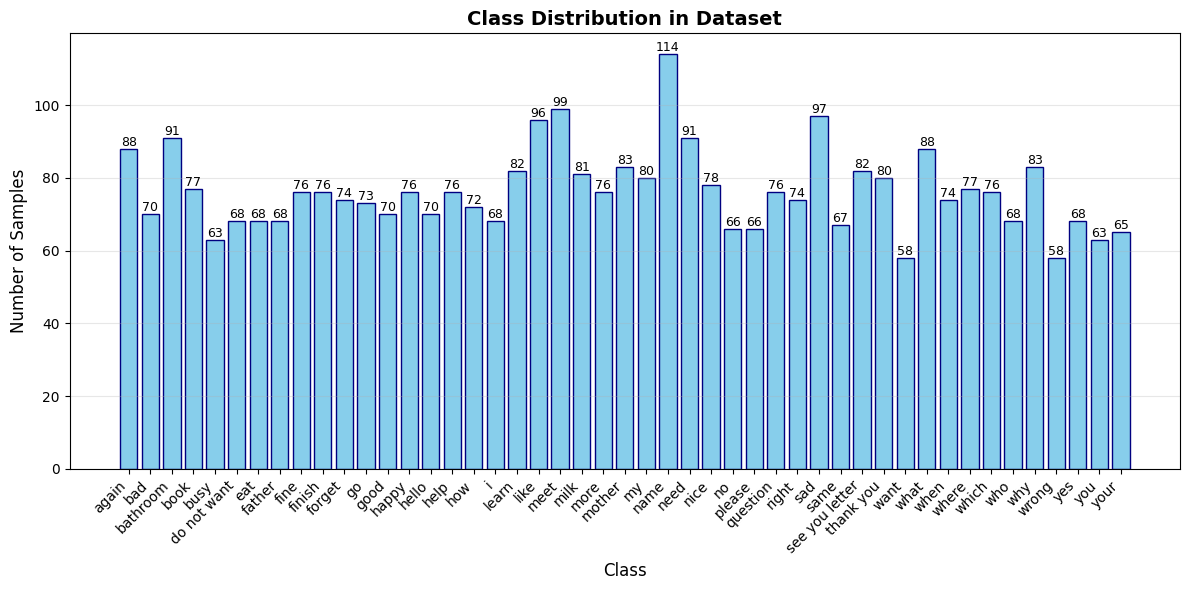


Class imbalance ratio (max/min): 1.97


In [7]:
# Inspect dataset features and extract label information
split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
train_data = dataset[split_name]

print(f"Dataset features: {train_data.features}")
print(f"\nNumber of samples: {len(train_data)}")

# Extract label names
label_feature = train_data.features['label']
if hasattr(label_feature, 'names'):
    label_names = label_feature.names
else:
    # Try to infer labels from the data
    unique_labels = set(train_data['label'])
    label_names = [f"Class_{i}" for i in range(len(unique_labels))]

num_classes = len(label_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {label_names}")

# Compute class distribution
from collections import Counter
label_counts = Counter(train_data['label'])
sorted_labels = sorted(label_counts.items())

# Plot class distribution
fig, ax = plt.subplots(figsize=(12, 6))
labels_text = [label_names[i] for i, _ in sorted_labels]
counts = [count for _, count in sorted_labels]

bars = ax.bar(range(len(labels_text)), counts, color='skyblue', edgecolor='navy')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(labels_text)))
ax.set_xticklabels(labels_text, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Check for class imbalance
min_count = min(counts)
max_count = max(counts)
imbalance_ratio = max_count / min_count
print(f"\nClass imbalance ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("⚠️ Significant class imbalance detected. Consider using weighted loss or resampling.")

## 5. Train/Validation Split

In [8]:
# Create train/validation split if validation doesn't exist
if 'validation' not in dataset and 'test' not in dataset:
    print("No validation split found. Creating stratified train/validation split...")
    
    # Stratified split to maintain class distribution
    split_dataset = train_data.train_test_split(
        test_size=0.2,
        seed=SEED,
        stratify_by_column='label'
    )
    
    train_dataset = split_dataset['train']
    val_dataset = split_dataset['test']
    test_dataset = None
    
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    
elif 'test' in dataset:
    train_dataset = dataset['train']
    val_dataset = dataset['test']
    test_dataset = None
    print(f"Using existing test split as validation")
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    
else:
    train_dataset = dataset['train']
    val_dataset = dataset['validation']
    test_dataset = dataset.get('test', None)
    print(f"Using existing validation split")
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    if test_dataset:
        print(f"Test set size: {len(test_dataset)}")

No validation split found. Creating stratified train/validation split...
Train set size: 2872
Validation set size: 718


## 6. Define Image Transforms and Augmentations

In [9]:
# Define image transformations
IMG_SIZE = 224  # Standard size for pretrained models

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms without augmentation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image transforms defined:")
print(f"- Input size: {IMG_SIZE}x{IMG_SIZE}")
print("- Training: Resize, RandomFlip, Rotation, ColorJitter, Affine, Normalize")
print("- Validation: Resize, CenterCrop, Normalize")

Image transforms defined:
- Input size: 224x224
- Training: Resize, RandomFlip, Rotation, ColorJitter, Affine, Normalize
- Validation: Resize, CenterCrop, Normalize


## 7. Build DataLoaders (PyTorch + Datasets set_transform)

In [10]:
# Convert video samples to single representative frame images using OpenCV (no torchcodec)
import os
import io
import hashlib
import zipfile
from pathlib import Path
from typing import Optional
import cv2
from PIL import Image
from datasets import disable_caching

# Optional: disable datasets caching to avoid storing PIL objects in cache files
# disable_caching()

CACHE_DIR = Path(".cache_asl_videos").resolve()
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Ensure any previous transforms are neutralized before mapping
try:
    train_dataset.set_transform(lambda x: x)
    val_dataset.set_transform(lambda x: x)
    train_dataset.reset_format()
    val_dataset.reset_format()
except Exception:
    pass


def _parse_zip_url(url: str):
    """Parse a datasets-style zip URL (zip://inner::C:\\path\\to.zip)."""
    assert url.startswith("zip://"), f"Not a zip url: {url}"
    rest = url[len("zip://"):]
    inner, outer = rest.split("::", 1)
    return inner, outer


def _ensure_extracted(outer_zip: str, inner_path: str) -> Path:
    """Extract inner_path from outer_zip into deterministic cache and return local path."""
    h = hashlib.sha1(f"{outer_zip}|{inner_path}".encode()).hexdigest()[:16]
    target_dir = CACHE_DIR / h
    target_dir.mkdir(parents=True, exist_ok=True)
    target_file = target_dir / Path(inner_path).name
    if not target_file.exists():
        with zipfile.ZipFile(outer_zip, "r") as zf:
            zf.extract(inner_path, path=target_dir)
        # When extracting with a nested path, the file may be under subdirs; fix path
        maybe_path = target_dir / inner_path
        if maybe_path.exists():
            maybe_path = maybe_path
        else:
            # Fallback to direct file in target_dir
            maybe_path = target_file
        if maybe_path != target_file:
            # Move file to target_file for stable location
            os.replace(str(maybe_path), str(target_file))
            # Clean empty dirs
            try:
                subdir = (target_dir / Path(inner_path).parent)
                if subdir.exists():
                    for root, dirs, files in os.walk(subdir, topdown=False):
                        for name in files:
                            try:
                                (Path(root) / name).unlink()
                            except Exception:
                                pass
                        for name in dirs:
                            try:
                                (Path(root) / name).rmdir()
                            except Exception:
                                pass
                    subdir.rmdir()
            except Exception:
                pass
    return target_file


def _video_to_pil_first_good_frame(video_path: str, fallback_size=(IMG_SIZE, IMG_SIZE)) -> Image.Image:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        # Fallback: blank image
        return Image.new("RGB", fallback_size, color=(0, 0, 0))
    # Try to grab a middle frame; if not available, grab first non-empty
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    try_positions = []
    if frame_count > 0:
        try_positions = [frame_count // 2, frame_count // 3, frame_count // 4, 0]
    else:
        try_positions = [0]
    img = None
    for pos in try_positions:
        if pos > 0:
            cap.set(cv2.CAP_PROP_POS_FRAMES, pos)
        ok, frame = cap.read()
        if ok and frame is not None and frame.size > 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame_rgb)
            break
    cap.release()
    if img is None:
        img = Image.new("RGB", fallback_size, color=(0, 0, 0))
    return img


def _resolve_video_path(video_field) -> Optional[str]:
    # video_field may be dict with 'path' or a string
    path = None
    if isinstance(video_field, dict):
        path = video_field.get("path")
    elif isinstance(video_field, str):
        path = video_field
    if path is None:
        return None
    # Handle zip URL from datasets
    if isinstance(path, str) and path.startswith("zip://"):
        inner, outer = _parse_zip_url(path)
        local_path = _ensure_extracted(outer, inner)
        return str(local_path)
    return path


# Create an 'image' column with PIL Images derived from the videos
from tqdm.auto import tqdm as _tqdm

print("Creating 'image' column by extracting representative frames from videos... (this runs once and caches)")

def add_image_column(example):
    vpath = _resolve_video_path(example['video'])
    if vpath is None:
        img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color=(0, 0, 0))
    else:
        img = _video_to_pil_first_good_frame(vpath, fallback_size=(IMG_SIZE, IMG_SIZE))
    return {"image": img}

# Map over train/val datasets (single-process to avoid Windows spawn issues)
train_dataset = train_dataset.map(add_image_column, desc="Extracting frames (train)")
val_dataset = val_dataset.map(add_image_column, desc="Extracting frames (val)")

# Apply transforms using set_transform
def transform_train(examples):
    images = [train_transform(img.convert('RGB')) for img in examples['image']]
    return {'image': images, 'label': examples['label']}


def transform_val(examples):
    images = [val_transform(img.convert('RGB')) for img in examples['image']]
    return {'image': images, 'label': examples['label']}

train_dataset.set_transform(transform_train)
val_dataset.set_transform(transform_val)

# Custom collate function
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return images, labels

# Create DataLoaders (use fewer workers on Windows to avoid multiprocessing issues)
BATCH_SIZE = 32
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True,
)

print(f"DataLoaders created:")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Train batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Workers: {NUM_WORKERS}")

# Test data loading
sample_batch = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch[0].shape}, {sample_batch[1].shape}")

Creating 'image' column by extracting representative frames from videos... (this runs once and caches)


Extracting frames (train):   0%|          | 0/2872 [00:00<?, ? examples/s]

Extracting frames (val):   0%|          | 0/718 [00:00<?, ? examples/s]

DataLoaders created:
- Batch size: 32
- Train batches: 90
- Validation batches: 23
- Workers: 0

Sample batch shape: torch.Size([32, 3, 224, 224]), torch.Size([32])

Sample batch shape: torch.Size([32, 3, 224, 224]), torch.Size([32])


## 8. Define Label Map and Persist Class Index

In [11]:
# Create class index mappings
class_to_idx = {name: idx for idx, name in enumerate(label_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# Save class mappings
output_dir = Path('backend/models')
output_dir.mkdir(parents=True, exist_ok=True)

class_mapping = {
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'num_classes': num_classes,
    'label_names': label_names
}

with open(output_dir / 'class_mapping.json', 'w') as f:
    json.dump(class_mapping, f, indent=2)

print("Class mappings saved to 'backend/models/class_mapping.json'")
print(f"\nClass to Index mapping:")
for i, (name, idx) in enumerate(class_to_idx.items()):
    print(f"  {idx}: {name}")
    if i >= 9:  # Show first 10
        print(f"  ... and {len(class_to_idx) - 10} more")
        break

Class mappings saved to 'backend/models/class_mapping.json'

Class to Index mapping:
  0: again
  1: bad
  2: bathroom
  3: book
  4: busy
  5: do not want
  6: eat
  7: father
  8: fine
  9: finish
  ... and 37 more


## 9. Model: CNN Transfer Learning Backbone

We use a **Convolutional Neural Network (CNN)** architecture for sign language recognition. CNNs are ideal for image classification because they:
- Extract spatial features from images (edges, shapes, patterns)
- Learn hierarchical representations automatically
- Are translation-invariant (recognize gestures regardless of position)

**Available CNN architectures:**
- `resnet18`, `resnet34`, `resnet50` - Deep residual networks
- `efficientnet_b0`, `efficientnet_b1` - Efficient and accurate
- `mobilenetv3_small_100` - Lightweight for mobile/edge devices

In [13]:
# Section 9 — Model (CNN) without HF Hub auth issues
# Prefer torchvision's ResNet18 pretrained weights; fallback to timm (scratch) if needed
import torch
import torch.nn as nn

MODEL_NAME = 'resnet18'  # kept for logging/reference
FREEZE_BACKBONE = False  # set True to fine-tune only the final layer

model = None
model_source = None

try:
    from torchvision import models
    from torchvision.models import ResNet18_Weights
    print("[Model] Using torchvision.resnet18 with IMAGENET1K_V1 weights (no Hugging Face auth)")
    backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    in_feats = backbone.fc.in_features
    backbone.fc = nn.Linear(in_feats, num_classes)
    model = backbone.to(device)
    model_source = "torchvision-pretrained"
except Exception as e_tv:
    print(f"[Model] torchvision pretrained load failed: {e_tv}")
    try:
        import timm
        print("[Model] Falling back to timm resnet18 WITHOUT pretrained weights to avoid HF Hub 401/authorization issues")
        model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)
        model = model.to(device)
        model_source = "timm-scratch"
    except Exception as e_timm:
        raise RuntimeError(f"Failed to create model with both torchvision and timm. Errors: tv={e_tv} | timm={e_timm}")

print(f"[Model] Source: {model_source}")
print(f"[Model] Device: {device}")

# Optionally freeze backbone parameters (keep classifier trainable)
if FREEZE_BACKBONE:
    frozen, trainable = 0, 0
    for name, p in model.named_parameters():
        # For torchvision.resnet, classifier is 'fc.*'; for timm resnet, classifier is 'fc.*' as well
        if name.startswith('fc.'):
            p.requires_grad = True
            trainable += p.numel()
        else:
            p.requires_grad = False
            frozen += p.numel()
    print(f"[Model] FREEZE_BACKBONE=True -> Frozen params: {frozen:,}, Trainable params: {trainable:,}")

# Quick shape smoke test
model.eval()
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
    out = model(dummy)
    print("[Model] Dummy output shape:", tuple(out.shape))
model.train()

[Model] Using torchvision.resnet18 with IMAGENET1K_V1 weights (no Hugging Face auth)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sana/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sana/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:15<00:00, 3.02MB/s]



[Model] Source: torchvision-pretrained
[Model] Device: cpu
[Model] Dummy output shape: (1, 47)
[Model] Dummy output shape: (1, 47)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 10. Loss, Metrics, and Optimizer Setup

The Cross-Entropy Loss is defined as: $\mathcal{L}_{CE} = -\sum_{i} y_i \log(\hat{y}_i)$

In [14]:
# Loss function with optional class weights for imbalance
USE_CLASS_WEIGHTS = False

if USE_CLASS_WEIGHTS and imbalance_ratio > 2:
    # Calculate class weights
    class_counts = torch.tensor([label_counts[i] for i in range(num_classes)], dtype=torch.float)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * num_classes
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    print("Using weighted Cross-Entropy Loss")
else:
    criterion = nn.CrossEntropyLoss()
    print("Using Cross-Entropy Loss")

# Optimizer
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
NUM_EPOCHS = 20
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

# Metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes).to(device)
f1_metric = F1Score(task='multiclass', num_classes=num_classes, average='macro').to(device)

print(f"\nTraining Configuration:")
print(f"- Optimizer: AdamW")
print(f"- Learning Rate: {LEARNING_RATE}")
print(f"- Weight Decay: {WEIGHT_DECAY}")
print(f"- Scheduler: CosineAnnealingWarmRestarts")
print(f"- Epochs: {NUM_EPOCHS}")
print(f"- Metrics: Accuracy, Macro F1-Score")

Using Cross-Entropy Loss

Training Configuration:
- Optimizer: AdamW
- Learning Rate: 0.001
- Weight Decay: 0.0001
- Scheduler: CosineAnnealingWarmRestarts
- Epochs: 20
- Metrics: Accuracy, Macro F1-Score

Training Configuration:
- Optimizer: AdamW
- Learning Rate: 0.001
- Weight Decay: 0.0001
- Scheduler: CosineAnnealingWarmRestarts
- Epochs: 20
- Metrics: Accuracy, Macro F1-Score


# Training and validation functions
from torch.cuda.amp import autocast, GradScaler

# Initialize gradient scaler for mixed precision training
scaler = GradScaler()

def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    accuracy_metric.reset()
    f1_metric.reset()
    
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Update metrics
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        accuracy_metric.update(preds, labels)
        f1_metric.update(preds, labels)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{accuracy_metric.compute().item():.4f}'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    
    return epoch_loss, epoch_acc, epoch_f1

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    accuracy_metric.reset()
    f1_metric.reset()
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    
    return epoch_loss, epoch_acc, epoch_f1

print("Training and validation functions defined!")

In [15]:
# Training and validation functions
from torch.cuda.amp import autocast, GradScaler

# Initialize GradScaler for mixed precision training
scaler = GradScaler() if device.type == 'cuda' else None

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    accuracy_metric.reset()
    f1_metric.reset()
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        
        # Update metrics
        preds = outputs.argmax(dim=1)
        accuracy_metric.update(preds, labels)
        f1_metric.update(preds, labels)
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    
    return epoch_loss, epoch_acc, epoch_f1

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    accuracy_metric.reset()
    f1_metric.reset()
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Update metrics
            preds = outputs.argmax(dim=1)
            accuracy_metric.update(preds, labels)
            f1_metric.update(preds, labels)
            
            pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()
    
    return epoch_loss, epoch_acc, epoch_f1

print("Training functions defined. Ready to start training!")

Training functions defined. Ready to start training!


In [16]:
# Main training loop
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_acc = 0.0
best_val_f1 = 0.0
patience = 5
patience_counter = 0

checkpoint_dir = output_dir / 'checkpoints'
checkpoint_dir.mkdir(exist_ok=True)

print(f"Starting training for {NUM_EPOCHS} epochs...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, scaler, device
    )
    
    # Validate
    val_loss, val_acc, val_f1 = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step()
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    # Print epoch results
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_f1 = val_f1
        patience_counter = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_f1': val_f1,
            'num_classes': num_classes,
            'model_name': MODEL_NAME
        }
        
        torch.save(checkpoint, checkpoint_dir / 'best_model.pt')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Validation F1-Score: {best_val_f1:.4f}")

Starting training for 20 epochs...

Epoch 1/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 1.1190 | Acc: 0.6915 | F1: 0.6891
Val Loss: 0.5456 | Acc: 0.8579 | F1: 0.8414
Learning Rate: 0.000905
✓ Best model saved! (Val Acc: 0.8579, Val F1: 0.8414)

Epoch 2/20
------------------------------------------------------------
✓ Best model saved! (Val Acc: 0.8579, Val F1: 0.8414)

Epoch 2/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.2651 | Acc: 0.9290 | F1: 0.9276
Val Loss: 0.2069 | Acc: 0.9415 | F1: 0.9355
Learning Rate: 0.000655
✓ Best model saved! (Val Acc: 0.9415, Val F1: 0.9355)

Epoch 3/20
------------------------------------------------------------
✓ Best model saved! (Val Acc: 0.9415, Val F1: 0.9355)

Epoch 3/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1057 | Acc: 0.9714 | F1: 0.9707
Val Loss: 0.0990 | Acc: 0.9777 | F1: 0.9775
Learning Rate: 0.000346
✓ Best model saved! (Val Acc: 0.9777, Val F1: 0.9775)

Epoch 4/20
------------------------------------------------------------
✓ Best model saved! (Val Acc: 0.9777, Val F1: 0.9775)

Epoch 4/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.0548 | Acc: 0.9868 | F1: 0.9865
Val Loss: 0.0455 | Acc: 0.9861 | F1: 0.9854
Learning Rate: 0.000096
✓ Best model saved! (Val Acc: 0.9861, Val F1: 0.9854)

Epoch 5/20
------------------------------------------------------------
✓ Best model saved! (Val Acc: 0.9861, Val F1: 0.9854)

Epoch 5/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.0317 | Acc: 0.9923 | F1: 0.9921
Val Loss: 0.0316 | Acc: 0.9903 | F1: 0.9900
Learning Rate: 0.001000
✓ Best model saved! (Val Acc: 0.9903, Val F1: 0.9900)

Epoch 6/20
------------------------------------------------------------
✓ Best model saved! (Val Acc: 0.9903, Val F1: 0.9900)

Epoch 6/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.2190 | Acc: 0.9377 | F1: 0.9367
Val Loss: 1.0039 | Acc: 0.7284 | F1: 0.6962
Learning Rate: 0.000976
No improvement. Patience: 1/5

Epoch 7/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.2718 | Acc: 0.9210 | F1: 0.9191
Val Loss: 0.3888 | Acc: 0.8747 | F1: 0.8785
Learning Rate: 0.000905
No improvement. Patience: 2/5

Epoch 8/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1257 | Acc: 0.9600 | F1: 0.9587
Val Loss: 0.3093 | Acc: 0.9081 | F1: 0.9052
Learning Rate: 0.000794
No improvement. Patience: 3/5

Epoch 9/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.0715 | Acc: 0.9833 | F1: 0.9829
Val Loss: 0.0866 | Acc: 0.9680 | F1: 0.9662
Learning Rate: 0.000655
No improvement. Patience: 4/5

Epoch 10/20
------------------------------------------------------------


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.0384 | Acc: 0.9892 | F1: 0.9889
Val Loss: 0.0398 | Acc: 0.9875 | F1: 0.9870
Learning Rate: 0.000501
No improvement. Patience: 5/5

Early stopping triggered after 10 epochs

Training completed!
Best Validation Accuracy: 0.9903
Best Validation F1-Score: 0.9900


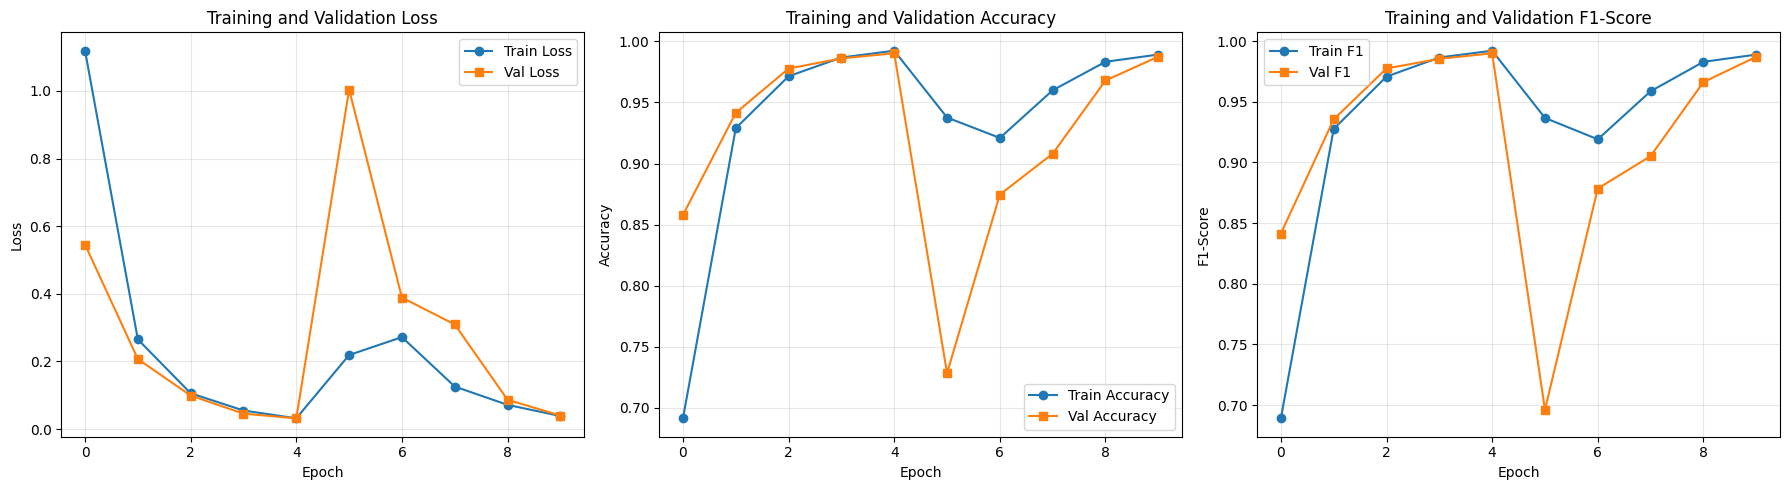

Training history plots saved!


In [17]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# F1-Score plot
axes[2].plot(history['train_f1'], label='Train F1', marker='o')
axes[2].plot(history['val_f1'], label='Val F1', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('Training and Validation F1-Score')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plots saved!")

## 12. Evaluation: Accuracy, F1, Confusion Matrix

Loading best model checkpoint...
Loaded model from epoch 5 with Val Acc: 0.9903
Loaded model from epoch 5 with Val Acc: 0.9903


Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]


Classification Report:
                precision    recall  f1-score   support

         again       0.94      1.00      0.97        17
           bad       1.00      1.00      1.00        14
      bathroom       1.00      1.00      1.00        18
          book       1.00      1.00      1.00        15
          busy       1.00      1.00      1.00        13
   do not want       1.00      1.00      1.00        14
           eat       1.00      1.00      1.00        14
        father       1.00      1.00      1.00        14
          fine       1.00      0.93      0.97        15
        finish       1.00      1.00      1.00        15
        forget       0.88      1.00      0.94        15
            go       1.00      0.80      0.89        15
          good       1.00      1.00      1.00        14
         happy       1.00      1.00      1.00        15
         hello       0.93      1.00      0.97        14
          help       1.00      1.00      1.00        15
           how       1.

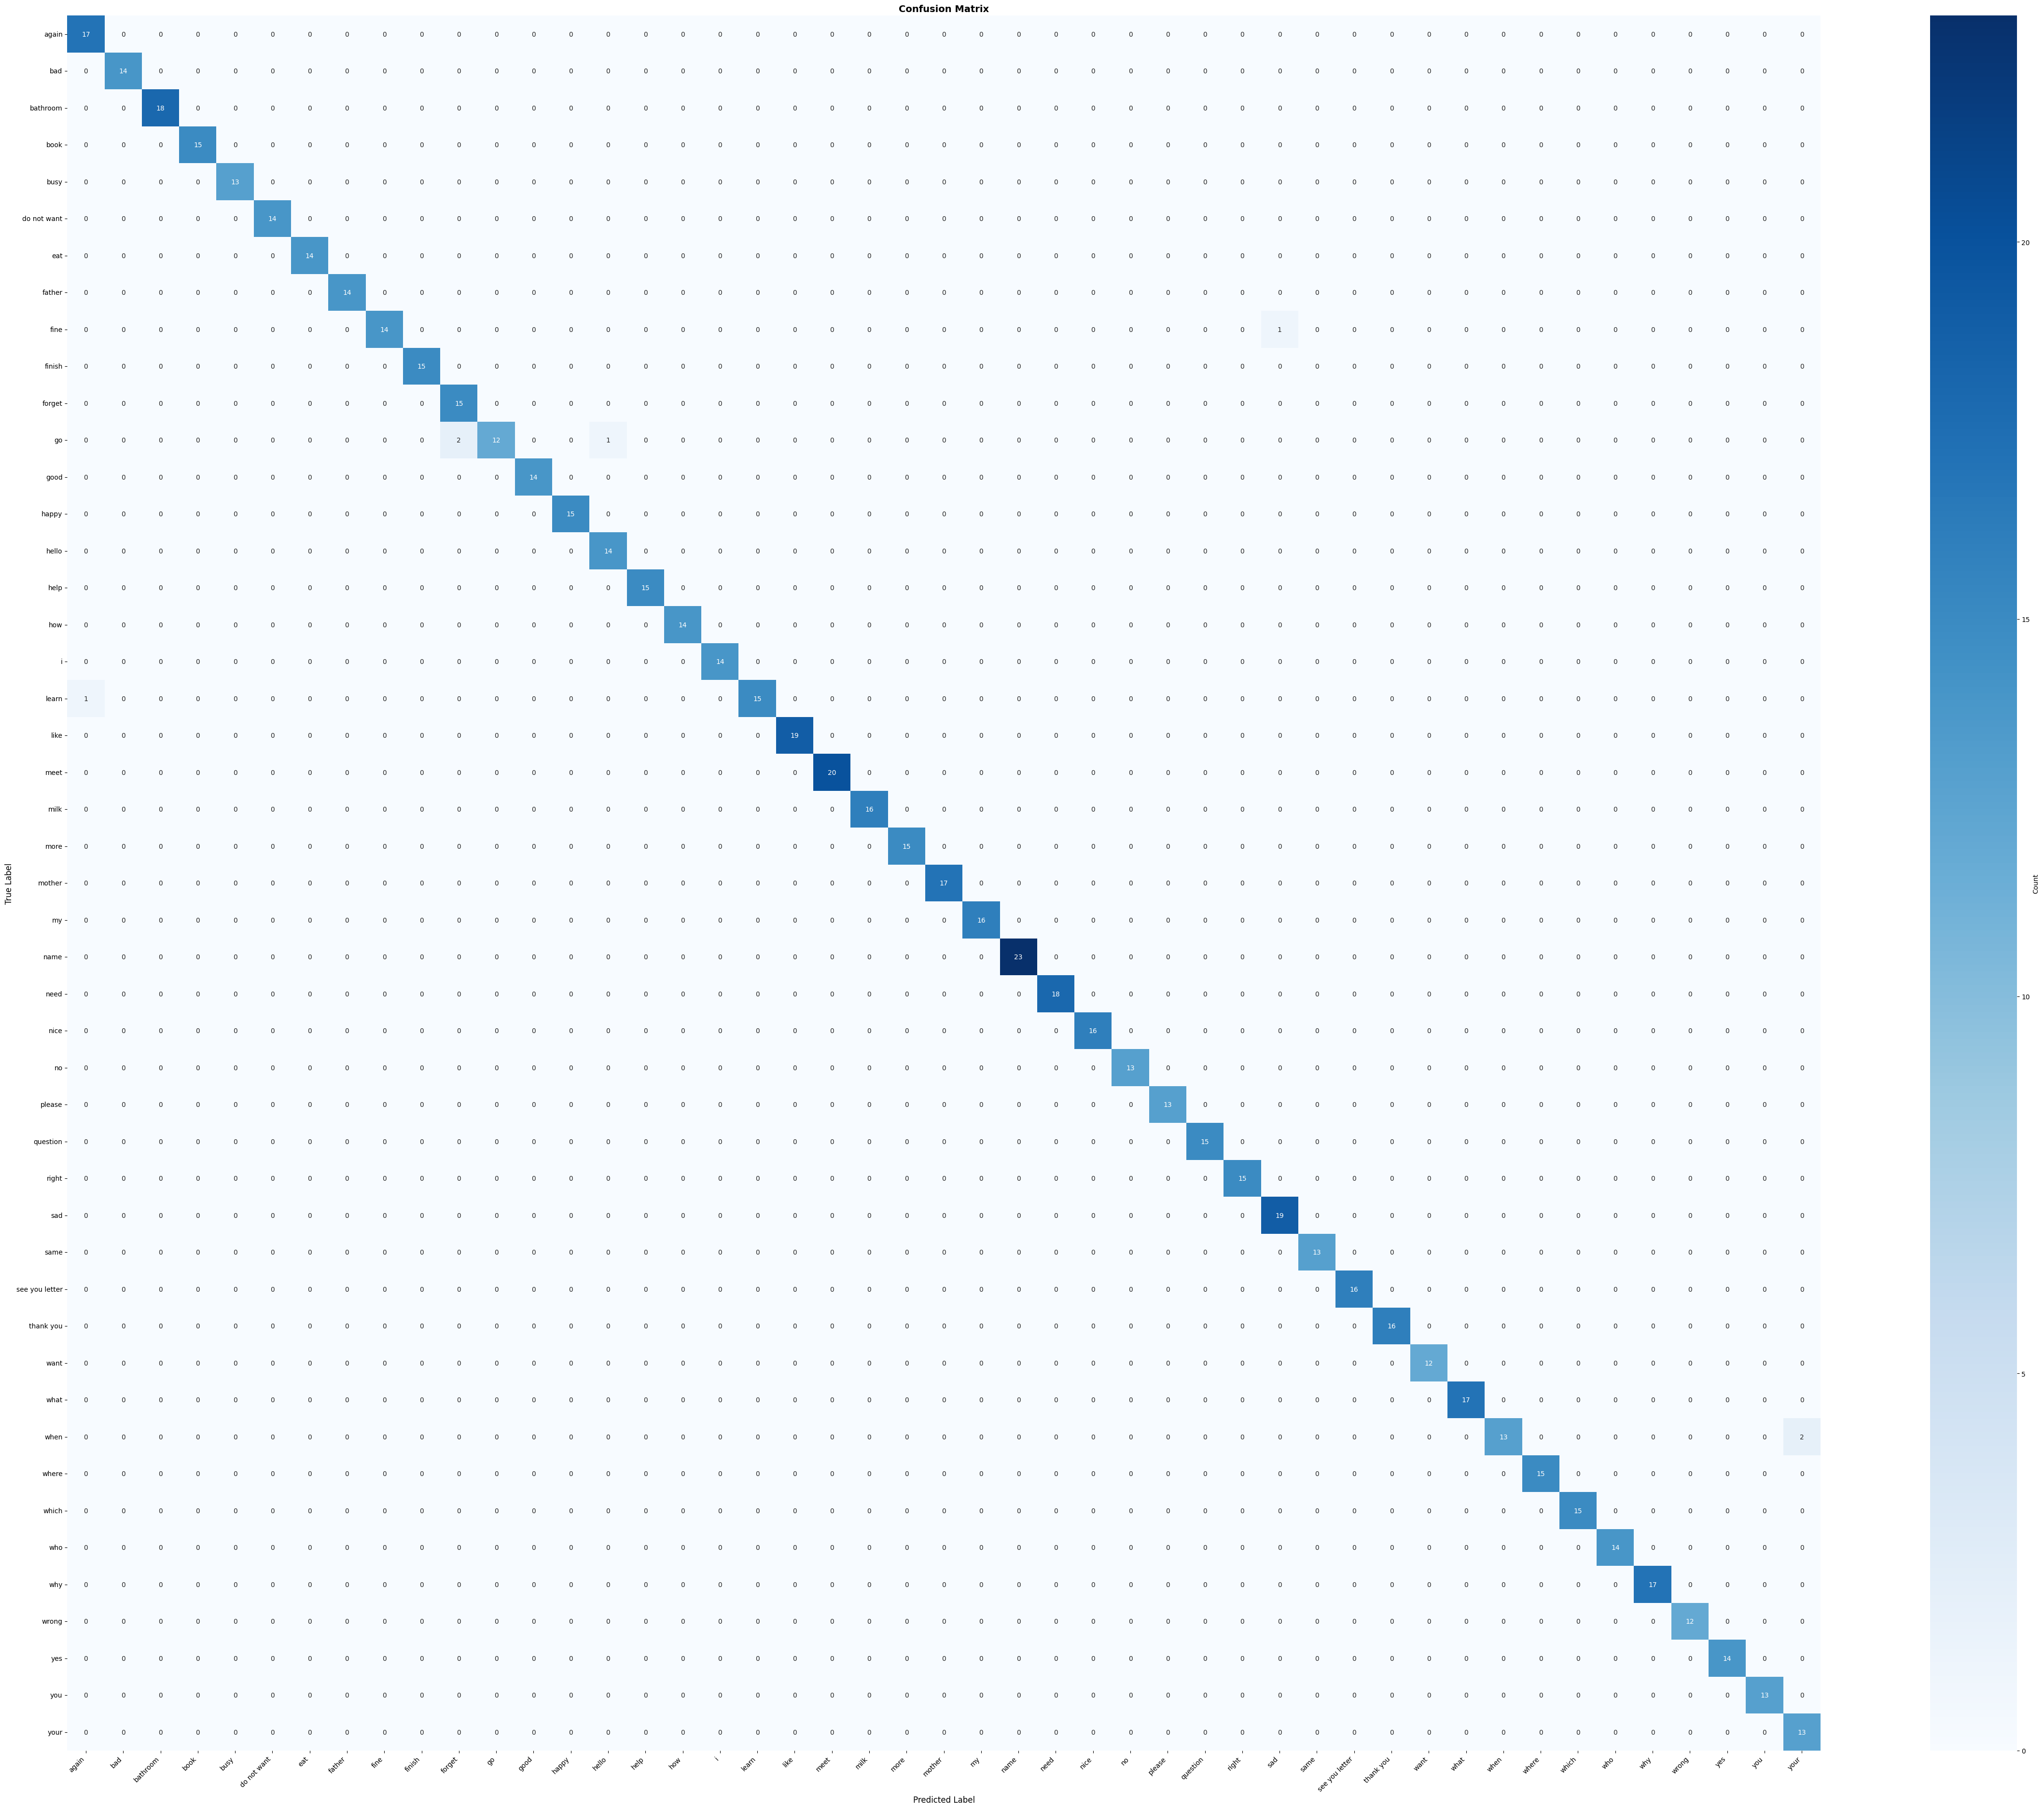


Confusion matrix saved!


In [18]:
# Load best model for evaluation
print("Loading best model checkpoint...")
checkpoint = torch.load(checkpoint_dir / 'best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with Val Acc: {checkpoint['val_acc']:.4f}")

# Evaluate on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Evaluating'):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(max(12, num_classes), max(10, num_classes * 0.8)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved!")

## 13. Error Analysis: Visualize Misclassifications

Finding misclassifications:   0%|          | 0/23 [00:00<?, ?it/s]

Found 7 misclassified samples


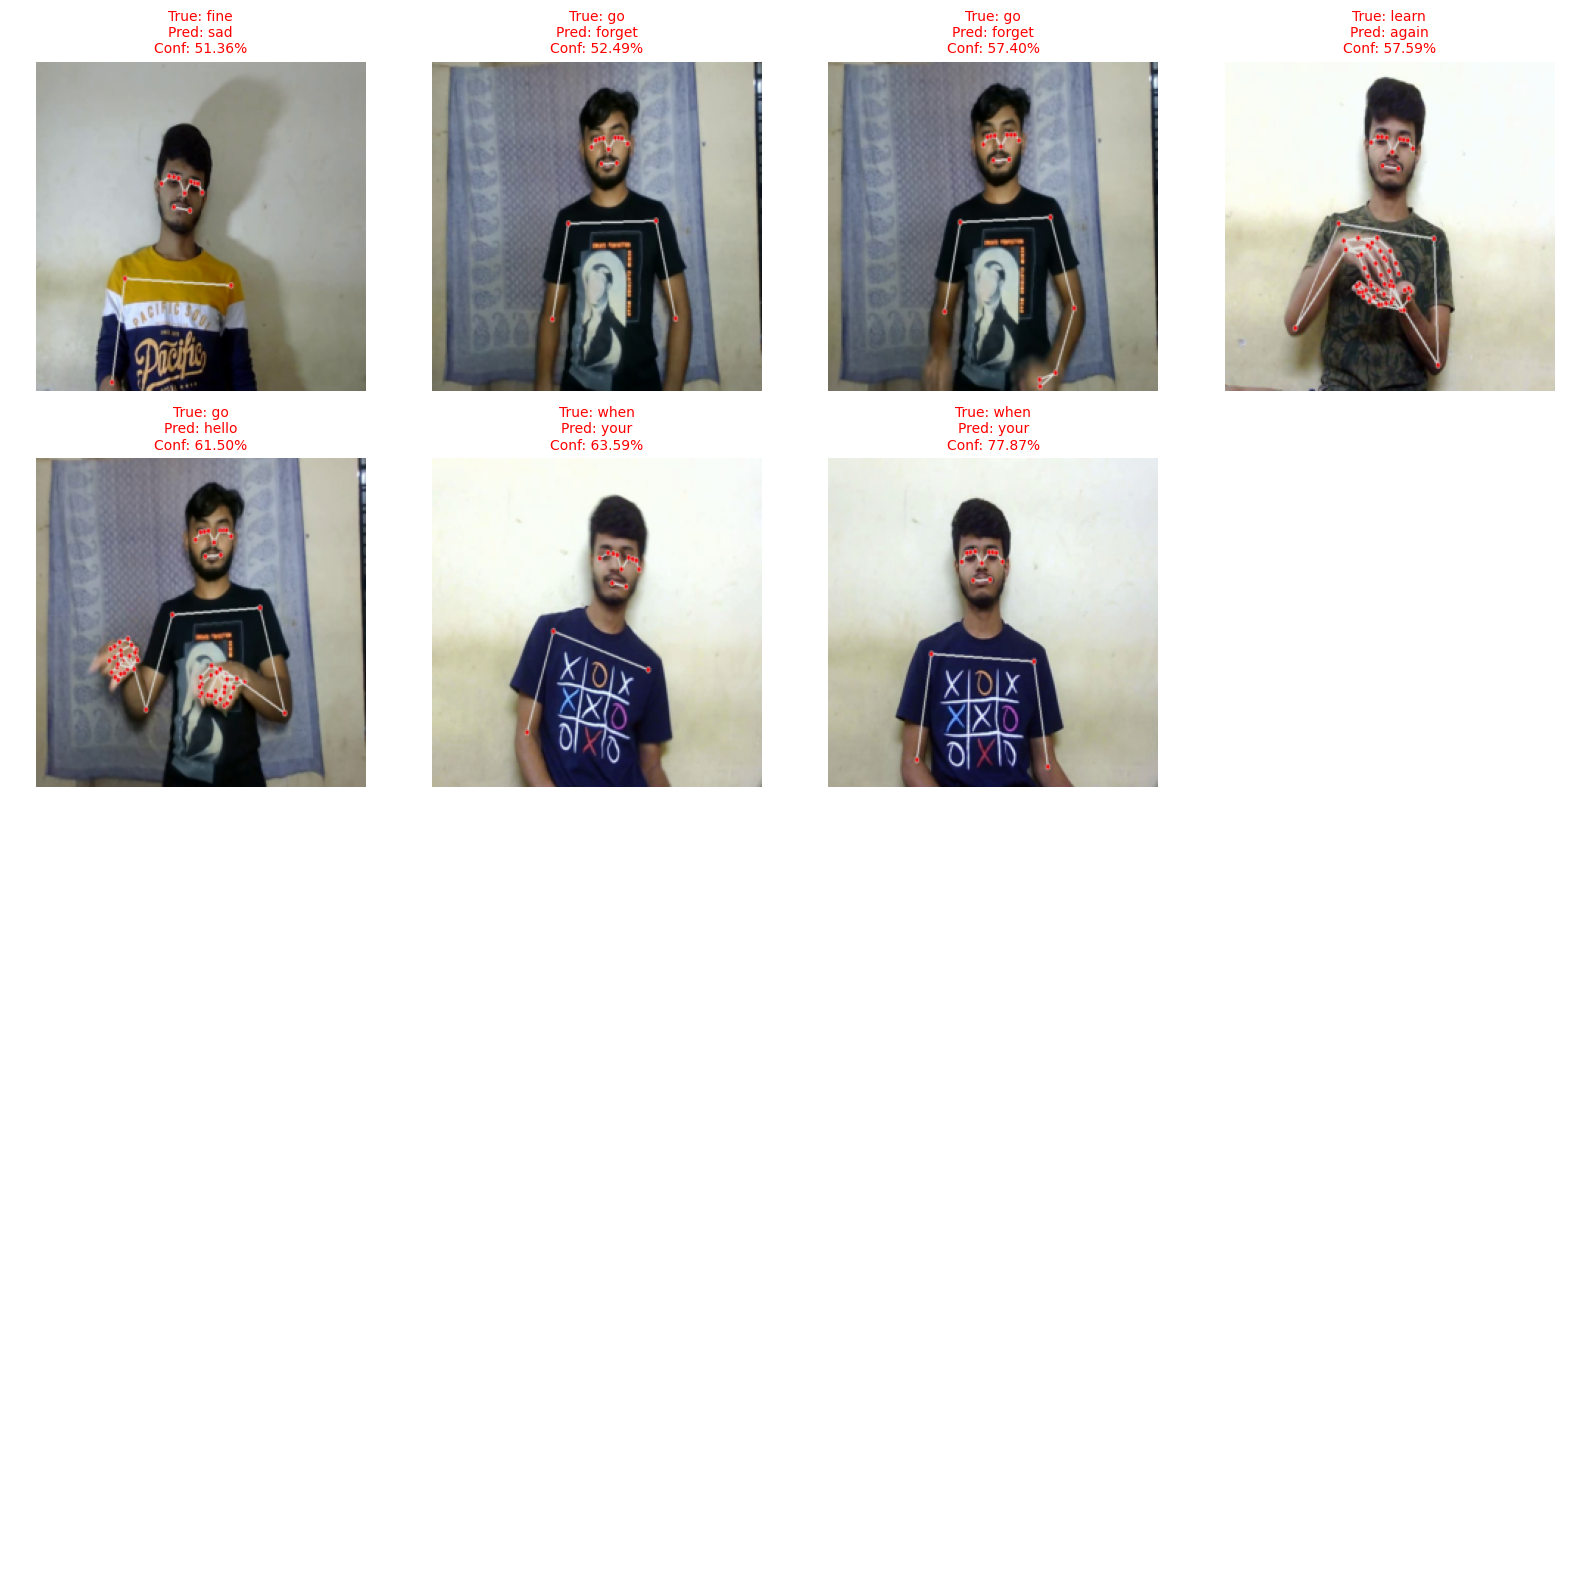

Misclassification visualization saved!


In [19]:
# Collect misclassified samples
misclassified = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Finding misclassifications'):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1).cpu()
        
        # Find misclassified samples
        mask = preds != labels
        if mask.any():
            for idx in mask.nonzero(as_tuple=True)[0]:
                misclassified.append({
                    'image': images[idx].cpu(),
                    'true_label': labels[idx].item(),
                    'pred_label': preds[idx].item(),
                    'confidence': probs[idx, preds[idx]].item()
                })

print(f"Found {len(misclassified)} misclassified samples")

# Visualize hardest misclassifications (lowest confidence in wrong prediction)
if len(misclassified) > 0:
    # Sort by confidence (ascending) to show the "most wrong" predictions
    misclassified_sorted = sorted(misclassified, key=lambda x: x['confidence'])[:16]
    
    # Denormalize function for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def denormalize(tensor):
        return tensor * std + mean
    
    # Plot misclassified samples
    num_samples = min(16, len(misclassified_sorted))
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    for idx, sample in enumerate(misclassified_sorted[:num_samples]):
        img = denormalize(sample['image']).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        true_label = label_names[sample['true_label']]
        pred_label = label_names[sample['pred_label']]
        confidence = sample['confidence']
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}",
            fontsize=10,
            color='red'
        )
    
    # Hide unused subplots
    for idx in range(num_samples, 16):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'misclassifications.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Misclassification visualization saved!")
else:
    print("No misclassifications found!")

## 14. Inference: Single Image Prediction Helper

Testing prediction function...

True label: wrong

Top 5 predictions:
1. wrong: 99.04%
2. thank you: 0.89%
3. fine: 0.02%
4. mother: 0.01%
5. bad: 0.01%

True label: wrong

Top 5 predictions:
1. wrong: 99.04%
2. thank you: 0.89%
3. fine: 0.02%
4. mother: 0.01%
5. bad: 0.01%


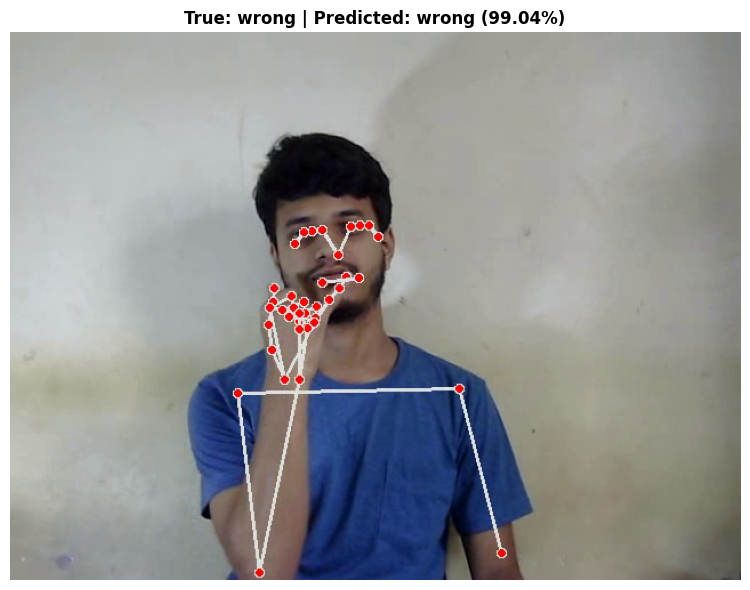


✅ Prediction test completed successfully!


In [24]:
def predict_image(image_input, model, transform, device, top_k=5):
    """
    Predict sign language gesture from an image
    
    Args:
        image_input: Can be a file path (str), PIL Image, numpy array, or torch.Tensor
        model: Trained PyTorch model
        transform: Transform to apply to the image
        device: Device to run inference on
        top_k: Number of top predictions to return
    
    Returns:
        Dictionary with top-k predictions and probabilities
    """
    # Load image
    if isinstance(image_input, str):
        image = Image.open(image_input).convert('RGB')
    elif isinstance(image_input, np.ndarray):
        image = Image.fromarray(image_input).convert('RGB')
    elif isinstance(image_input, Image.Image):
        image = image_input.convert('RGB')
    elif isinstance(image_input, torch.Tensor):
        # If already a tensor, assume it's already transformed
        img_tensor = image_input.unsqueeze(0) if image_input.dim() == 3 else image_input
        img_tensor = img_tensor.to(device)
    else:
        raise ValueError("Image input must be a file path, PIL Image, numpy array, or torch.Tensor")
    
    # Apply transform if needed
    if not isinstance(image_input, torch.Tensor):
        img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        top_probs, top_indices = torch.topk(probs, min(top_k, num_classes))
    
    # Format results
    predictions = []
    for prob, idx in zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()):
        predictions.append({
            'label': label_names[idx],
            'confidence': float(prob),
            'index': int(idx)
        })
    
    return predictions

# Test the prediction function on a sample from validation set
print("Testing prediction function...")

# IMPORTANT: Access the raw dataset by temporarily removing the transform
# Save the current transform function
current_transform = val_dataset._format_kwargs.get('transform') if hasattr(val_dataset, '_format_kwargs') else None

# Reset format to get raw PIL images
val_dataset.reset_format()
sample_idx = 0
raw_sample = val_dataset[sample_idx]
sample_image_pil = raw_sample['image']  # This is now a PIL Image
sample_label = raw_sample['label']

# Re-apply transforms for future use
def transform_val_func(examples):
    images = [val_transform(img.convert('RGB')) for img in examples['image']]
    return {'image': images, 'label': examples['label']}

val_dataset.set_transform(transform_val_func)

# Run prediction on the PIL Image
predictions = predict_image(sample_image_pil, model, val_transform, device, top_k=5)

print(f"\nTrue label: {label_names[sample_label]}")
print(f"\nTop 5 predictions:")
for i, pred in enumerate(predictions, 1):
    print(f"{i}. {pred['label']}: {pred['confidence']:.2%}")

# Visualize the sample
plt.figure(figsize=(8, 6))
plt.imshow(sample_image_pil)
plt.axis('off')
plt.title(f"True: {label_names[sample_label]} | Predicted: {predictions[0]['label']} ({predictions[0]['confidence']:.2%})", 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Prediction test completed successfully!")

## 15. Export: Save .pt and ONNX

In [26]:
# Save final model
print("Saving model...")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Save complete model state
final_model_path = output_dir / 'sign_language_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_name': MODEL_NAME,
    'num_classes': num_classes,
    'img_size': IMG_SIZE,
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class,
    'best_val_acc': best_val_acc,
    'best_val_f1': best_val_f1,
}, final_model_path)

print(f"✓ Model saved to: {final_model_path}")

# Export to ONNX
print("\nExporting to ONNX format...")
model.eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

onnx_path = output_dir / 'sign_language_model.onnx'

try:
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=12,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"✓ ONNX model saved to: {onnx_path}")
    
    # Verify ONNX model
    try:
        import onnxruntime as ort
        
        ort_session = ort.InferenceSession(str(onnx_path))
        
        # Test ONNX inference
        ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}
        ort_outputs = ort_session.run(None, ort_inputs)
        
        # Compare with PyTorch output
        with torch.no_grad():
            torch_output = model(dummy_input).cpu().numpy()
        
        np.testing.assert_allclose(torch_output, ort_outputs[0], rtol=1e-03, atol=1e-05)
        print("✓ ONNX model verification passed!")
    except Exception as e_ort:
        print(f"⚠️ ONNX verification skipped: {e_ort}")
    
except Exception as e:
    print(f"⚠️ ONNX export failed: {e}")
    print("   This is optional - the PyTorch .pt model is saved and can be used for inference.")

# Save model metadata
metadata = {
    'model_name': MODEL_NAME,
    'num_classes': num_classes,
    'img_size': IMG_SIZE,
    'best_val_acc': float(best_val_acc),
    'best_val_f1': float(best_val_f1),
    'training_date': str(np.datetime64('now')),
    'num_parameters': total_params,
    'trainable_parameters': trainable_params,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs_trained': len(history['val_acc']),
}

with open(output_dir / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Model metadata saved to: {output_dir / 'model_metadata.json'}")
print("\n" + "=" * 60)
print("Model export complete!")
print(f"Files saved in: {output_dir}")
print("  - sign_language_model.pt (PyTorch model)")
if onnx_path.exists():
    print("  - sign_language_model.onnx (ONNX model)")
print("  - class_mapping.json (Label mappings)")
print("  - model_metadata.json (Training info)")
print("  - checkpoints/best_model.pt (Best checkpoint)")
print("=" * 60)

Saving model...
Total parameters: 11,200,623
Trainable parameters: 11,200,623
✓ Model saved to: backend\models\sign_language_model.pt

Exporting to ONNX format...
⚠️ ONNX export failed: No module named 'onnxscript'
   This is optional - the PyTorch .pt model is saved and can be used for inference.

✓ Model metadata saved to: backend\models\model_metadata.json

Model export complete!
Files saved in: backend\models
  - sign_language_model.pt (PyTorch model)
  - class_mapping.json (Label mappings)
  - model_metadata.json (Training info)
  - checkpoints/best_model.pt (Best checkpoint)


## 16. Model Summary and Next Steps

In [27]:
# Print final summary
print("=" * 70)
print("AMERICAN SIGN LANGUAGE GESTURE RECOGNIZER - TRAINING SUMMARY")
print("=" * 70)
print(f"\n📊 Dataset Statistics:")
print(f"   • Total samples: {len(train_dataset) + len(val_dataset)}")
print(f"   • Training samples: {len(train_dataset)}")
print(f"   • Validation samples: {len(val_dataset)}")
print(f"   • Number of classes: {num_classes}")
print(f"   • Class imbalance ratio: {imbalance_ratio:.2f}")

print(f"\n🏗️ Model Architecture:")
print(f"   • Base model: {MODEL_NAME}")
print(f"   • Total parameters: {total_params:,}")
print(f"   • Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   • Output classes: {num_classes}")

print(f"\n📈 Training Results:")
print(f"   • Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   • Best validation F1-score: {best_val_f1:.4f}")
print(f"   • Epochs trained: {len(history['val_acc'])}/{NUM_EPOCHS}")
print(f"   • Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")

print(f"\n💾 Saved Files:")
print(f"   • PyTorch model: backend/models/sign_language_model.pt")
print(f"   • ONNX model: backend/models/sign_language_model.onnx")
print(f"   • Class mapping: backend/models/class_mapping.json")
print(f"   • Model metadata: backend/models/model_metadata.json")
print(f"   • Best checkpoint: backend/models/checkpoints/best_model.pt")

print(f"\n🎯 Next Steps:")
print(f"   1. Integrate the model into your application")
print(f"   2. Test on real-world sign language images/videos")
print(f"   3. Fine-tune on domain-specific data if needed")
print(f"   4. Consider model optimization (quantization, pruning)")
print(f"   5. Deploy using Flask/FastAPI backend")
print(f"   6. Monitor performance and collect user feedback")

print("\n" + "=" * 70)
print("Training pipeline completed successfully! ✨")
print("=" * 70)

AMERICAN SIGN LANGUAGE GESTURE RECOGNIZER - TRAINING SUMMARY

📊 Dataset Statistics:
   • Total samples: 3590
   • Training samples: 2872
   • Validation samples: 718
   • Number of classes: 47
   • Class imbalance ratio: 1.97

🏗️ Model Architecture:
   • Base model: resnet18
   • Total parameters: 11,200,623
   • Input size: 224x224
   • Output classes: 47

📈 Training Results:
   • Best validation accuracy: 0.9903 (99.03%)
   • Best validation F1-score: 0.9900
   • Epochs trained: 10/20
   • Final learning rate: 0.000501

💾 Saved Files:
   • PyTorch model: backend/models/sign_language_model.pt
   • ONNX model: backend/models/sign_language_model.onnx
   • Class mapping: backend/models/class_mapping.json
   • Model metadata: backend/models/model_metadata.json
   • Best checkpoint: backend/models/checkpoints/best_model.pt

🎯 Next Steps:
   1. Integrate the model into your application
   2. Test on real-world sign language images/videos
   3. Fine-tune on domain-specific data if needed
   

## 17. Real-Time Camera Inference

Test your trained model with live webcam feed! This section allows you to make sign language gestures in front of your camera and get real-time text translations.

In [28]:
# Install OpenCV for camera access
%pip install opencv-python -q

import cv2
from IPython.display import display, Image as IPImage, clear_output
import time

print("OpenCV installed successfully!")

Note: you may need to restart the kernel to use updated packages.
OpenCV installed successfully!


In [29]:
def preprocess_frame(frame, transform):
    """Preprocess camera frame for model input"""
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Convert to PIL Image
    pil_image = Image.fromarray(frame_rgb)
    # Apply transforms
    tensor = transform(pil_image).unsqueeze(0)
    return tensor

def draw_predictions(frame, predictions, fps=0):
    """Draw prediction results on frame"""
    # Create a semi-transparent overlay for text background
    overlay = frame.copy()
    
    # Draw FPS
    cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Draw prediction box
    box_height = 150
    cv2.rectangle(overlay, (10, 50), (400, 50 + box_height), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)
    
    # Draw title
    cv2.putText(frame, "Sign Language Detection", (20, 75),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Draw top predictions
    y_offset = 105
    for i, pred in enumerate(predictions[:3]):  # Show top 3
        label = pred['label']
        confidence = pred['confidence']
        
        # Color based on confidence
        if i == 0:
            color = (0, 255, 0) if confidence > 0.7 else (0, 255, 255)
        else:
            color = (200, 200, 200)
        
        text = f"{i+1}. {label}: {confidence:.1%}"
        cv2.putText(frame, text, (20, y_offset + i*25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Draw instructions
    cv2.putText(frame, "Press 'q' to quit", (10, frame.shape[0] - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return frame

print("Helper functions defined!")

Helper functions defined!


In [34]:
def run_camera_inference(model, transform, device, camera_index=0, inference_interval=0.1, max_frames=None):
    """
    Run real-time sign language detection on camera feed (Jupyter-compatible)
    
    Args:
        model: Trained PyTorch model
        transform: Image transform to apply
        device: Device to run inference on
        camera_index: Camera device index (0 for default webcam)
        inference_interval: Time between predictions in seconds (higher = less CPU usage)
        max_frames: Maximum number of frames to process (None = run until interrupted)
    
    Controls:
        - Run cell and press STOP button in Jupyter to quit
        - Or set max_frames to auto-stop after N frames
    """
    print("Starting camera... Press STOP button in Jupyter to quit")
    print("=" * 60)
    
    # Initialize camera
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print("❌ Error: Could not open camera!")
        print("Try changing camera_index (0, 1, 2, etc.)")
        return
    
    # Set camera properties for better performance
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    print("✅ Camera opened successfully!")
    print(f"Resolution: {int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))}x{int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))}")
    print("\nMake sign language gestures in front of the camera!")
    print("Press STOP button in Jupyter to quit")
    print("=" * 60)
    
    model.eval()
    last_inference_time = 0
    predictions = [{'label': 'Waiting...', 'confidence': 0.0}]
    frame_count = 0
    start_time = time.time()
    
    display_handle = display(IPImage(data=b''), display_id=True)
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("❌ Failed to grab frame")
                break
            
            current_time = time.time()
            frame_count += 1
            
            # Check if max_frames reached
            if max_frames is not None and frame_count >= max_frames:
                print(f"\n✅ Reached maximum frames ({max_frames})")
                break
            
            # Run inference at specified interval
            if current_time - last_inference_time >= inference_interval:
                # Preprocess frame
                input_tensor = preprocess_frame(frame, transform).to(device)
                
                # Run inference
                with torch.no_grad():
                    outputs = model(input_tensor)
                    probs = torch.softmax(outputs, dim=1)[0]
                    top_probs, top_indices = torch.topk(probs, min(5, num_classes))
                
                # Format predictions
                predictions = []
                for prob, idx in zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()):
                    predictions.append({
                        'label': label_names[idx],
                        'confidence': float(prob)
                    })
                
                last_inference_time = current_time
            
            # Calculate FPS
            fps = frame_count / (current_time - start_time)
            
            # Draw predictions on frame
            annotated_frame = draw_predictions(frame, predictions, fps)
            
            # Convert frame to JPEG for display in Jupyter
            _, buffer = cv2.imencode('.jpg', annotated_frame)
            
            # Update display
            display_handle.update(IPImage(data=buffer.tobytes()))
            
            # Small delay to allow interrupt
            time.sleep(0.01)
    
    except KeyboardInterrupt:
        print("\n\nInterrupted by user")
    
    finally:
        # Cleanup
        cap.release()
        
        # Print statistics
        total_time = time.time() - start_time
        avg_fps = frame_count / total_time if total_time > 0 else 0
        print("\n" + "=" * 60)
        print("Camera Session Summary:")
        print(f"  • Total frames: {frame_count}")
        print(f"  • Duration: {total_time:.1f}s")
        print(f"  • Average FPS: {avg_fps:.1f}")
        print("=" * 60)

print("Camera inference function ready (Jupyter-compatible)!")

Camera inference function ready (Jupyter-compatible)!


### 🎥 Start Real-Time Detection

Run the cell below to start the camera and test your model! Make sign language gestures in front of your camera.

**Note:** The video will display inline in the notebook (not in a separate window). 
- Press the **STOP** button in Jupyter to quit
- Or it will auto-stop after 300 frames (~10 seconds)
- Adjust `max_frames` parameter for longer/shorter sessions (set to `None` for infinite)

Starting camera... Press STOP button in Jupyter to quit
✅ Camera opened successfully!
Resolution: 640x480

Make sign language gestures in front of the camera!
Press STOP button in Jupyter to quit


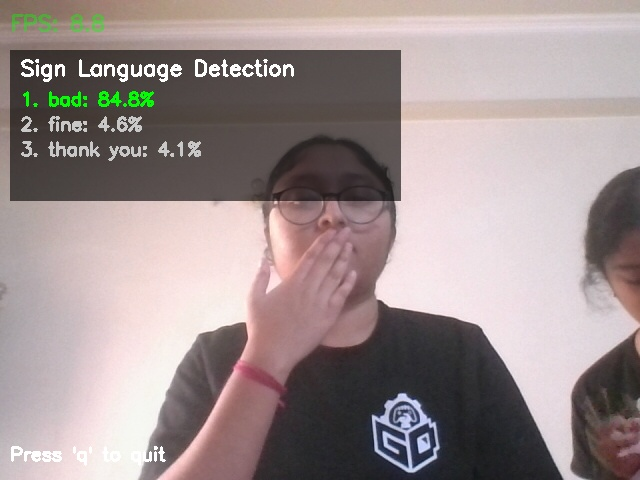


✅ Reached maximum frames (300)

Camera Session Summary:
  • Total frames: 300
  • Duration: 34.5s
  • Average FPS: 8.7

Camera Session Summary:
  • Total frames: 300
  • Duration: 34.5s
  • Average FPS: 8.7


In [35]:
# Run real-time camera inference in Jupyter notebook
# Make sure your trained model is loaded (should be from previous cells)

# Option 1: Run indefinitely (press STOP button in Jupyter to quit)
# run_camera_inference(
#     model=model,
#     transform=val_transform,
#     device=device,
#     camera_index=0,
#     inference_interval=0.1
# )

# Option 2: Run for a fixed number of frames (recommended for testing)
run_camera_inference(
    model=model,
    transform=val_transform,
    device=device,
    camera_index=0,
    inference_interval=0.1,
    max_frames=300  # Stops after 300 frames (~10 seconds at 30 FPS)
)

### 🔄 Alternative: Load Pre-trained Model for Inference Only

If you've already trained the model and just want to use it for camera inference without retraining:

✅ Model loaded from backend/models/sign_language_model.pt
   - Classes: 47
   - Accuracy: 99.03%
Starting camera... Press STOP button in Jupyter to quit
✅ Camera opened successfully!
Resolution: 640x480

Make sign language gestures in front of the camera!
Press STOP button in Jupyter to quit


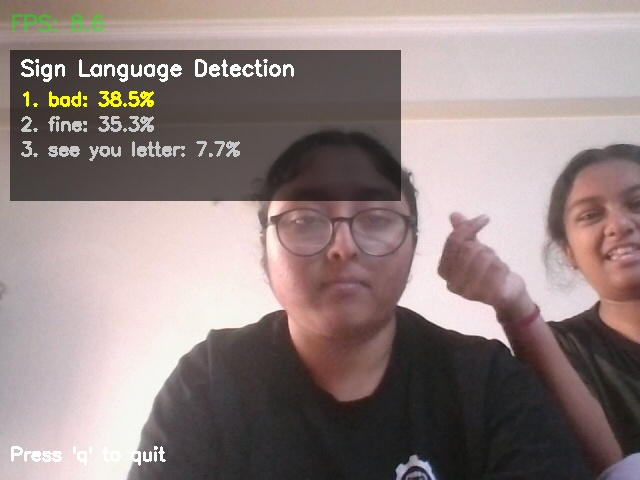



Interrupted by user

Camera Session Summary:
  • Total frames: 367
  • Duration: 43.0s
  • Average FPS: 8.5

Camera Session Summary:
  • Total frames: 367
  • Duration: 43.0s
  • Average FPS: 8.5


In [36]:
# Load a previously trained model
model_path = 'backend/models/sign_language_model.pt'
class_mapping_path = 'backend/models/class_mapping.json'

# Load class mappings
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)
    label_names = class_mapping['label_names']
    num_classes = class_mapping['num_classes']

# Load model checkpoint
checkpoint = torch.load(model_path, map_location=device)
model = timm.create_model(checkpoint['model_name'], pretrained=False, num_classes=num_classes)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ Model loaded from {model_path}")
print(f"   - Classes: {num_classes}")
print(f"   - Accuracy: {checkpoint['best_val_acc']:.2%}")

# Now run camera inference
run_camera_inference(model, val_transform, device, camera_index=0, inference_interval=0.1)